In [1]:
import sys
from jax import random
import matplotlib.pyplot as plt
sys.path.append("../")

from models.equivariant_gnn import NEQUIP 
from models.egnn import EGNN
import e3nn_jax as e3nn
from models.graph_utils import nearest_neighbors, rotate_representation

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-04-06 09:48:48.082933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/glib/2.56.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/12.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/12.1.0-fasrc01/lib:/n/helmod/apps/centos7/Core/cudnn/8.5.0.96_cuda11-fasrc01/lib:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/mpc/1.2.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/mpfr/4.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gmp/6.2.1-fasrc01/lib64
2023-04-06 09:48:48.083424: W tensorflow/compiler/xla/stream_executor/platform/defaul

In [2]:
import jax
import jax.numpy as np
import numpy as onp
import jax.numpy as jnp
import jraph
import flax.linen as nn

from functools import partial
import e3nn_jax as e3nn

In [3]:
n_nodes = 5000

In [4]:
x = np.load("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/halos.npy")[:, :n_nodes,:6]

In [5]:
#x = x.at[...,-1].set(np.log10(x[...,-1]))

In [6]:
x = (x - np.min(x, axis=0))/(np.max(x,axis=0) - np.min(x, axis=0))

In [7]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x[:4], 20)

In [8]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(NEQUIP(
          target_irreps=e3nn.Irreps('2x1o'),
          input_node_irreps=e3nn.Irreps('1o'),
        )
        )
        return model(x)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

In [9]:
graph = jraph.GraphsTuple(
          n_node=np.array(4 * [[n_nodes]]), 
          n_edge=np.array(4 * [[20]]),
          nodes=x[:4, :, :], 
          edges=None,
          globals=np.ones((4, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)
x_out = graph_out.nodes

#x_out = graph_out.nodes

angle_deg = 45.
axis = jnp.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)])

x_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x_out, angle_deg, axis)

graph = jraph.GraphsTuple(
          n_node=np.array(4 * [[n_nodes]]), 
          n_edge=np.array(4 * [[20]]),
          nodes=jax.vmap(rotate_representation, in_axes=(0,None,None))(x[:4, :, :], angle_deg, axis),
          edges=None,
          globals=np.ones((4, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)
x_out = graph_out.nodes


In [10]:
x_out

Array([[[-3.92511562e-02,  2.26113200e-02,  1.46758175e+00,
         -1.38196573e-01, -7.83844739e-02, -9.87322748e-01],
        [ 6.48591459e-01,  3.55460227e-01,  1.53276324e+00,
         -5.36513627e-01, -3.02950665e-02, -8.43406618e-01],
        [-9.66572523e-01,  1.84800804e-01,  1.74047470e-01,
          4.98775393e-01, -9.87088084e-02,  8.60105634e-01],
        ...,
        [ 4.32177544e-01, -1.14510834e-01,  1.41397905e+00,
         -3.31303239e-01, -4.77168441e-01,  8.14024329e-01],
        [ 1.09241974e+00,  5.71984410e-01,  1.08878684e+00,
         -2.18214646e-01, -7.00573251e-02, -9.73431528e-01],
        [ 7.92489588e-01,  1.58725381e-02,  1.44335008e+00,
          1.51855096e-01, -2.57182360e-01,  9.54368353e-01]],

       [[ 1.28425455e+00, -8.05574536e-01,  1.13942719e+00,
         -6.01731181e-01,  4.39949125e-01,  6.66672170e-01],
        [ 8.86854410e-01,  3.13297451e-01, -4.00760382e-01,
         -9.81579900e-01,  1.23455949e-01,  1.46101385e-01],
        [-2.66540

(array([680., 540., 450., 420., 421., 439., 436., 467., 500., 647.]),
 array([-9.9991030e-01, -7.9997677e-01, -6.0004318e-01, -4.0010965e-01,
        -2.0017609e-01, -2.4253130e-04,  1.9969103e-01,  3.9962459e-01,
         5.9955812e-01,  7.9949170e-01,  9.9942523e-01], dtype=float32),
 <BarContainer object of 10 artists>)

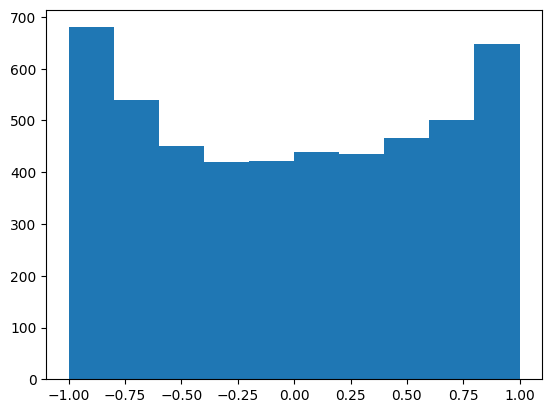

In [11]:
plt.hist(onp.array(x_out)[0,:,5])

In [12]:
# Equivariance ratio
eq_ratio = x_out / x_out_rot
print(eq_ratio.max(), eq_ratio.min(), eq_ratio)

nan nan [[[0.9999801  1.0000573  1.0000012  1.0000008  1.0000101  0.99999994]
  [1.0000014  1.000001   0.9999995  1.0000007  0.99998444 0.9999996 ]
  [1.0000001  1.0000021  0.99999976 1.0000001  1.0000035  0.99999994]
  ...
  [0.99999297 1.0000077  0.9999989  0.99998856 0.99999374 1.000004  ]
  [0.9999984  1.0000079  1.0000069  1.0000217  0.99988025 0.99999946]
  [0.9999793  1.0004677  1.0000093  0.9999904  1.0003049  0.99997807]]

 [[0.9999965  1.0000116  0.9999929  0.9999907  1.0000061  1.0000051 ]
  [0.9999941  1.000038   1.0000126  0.99999994 0.9999675  1.0000281 ]
  [0.9998694  0.9999838  1.0002235  0.99998134 0.999961   1.0001336 ]
  ...
  [0.9999999  1.0000001  0.9999999  1.0000007  0.9999995  1.0000033 ]
  [1.0000012  1.0000014  0.99991995 0.9999995  1.0000019  0.99999905]
  [0.9998387  1.000018   0.99996734 0.9995459  1.0004011  0.9999781 ]]

 [[1.0000073  1.0000026  0.99999464 0.99999994 1.0001022  0.9999832 ]
  [1.000008   0.9999966  1.0000004  1.0000023  0.999997   0.999995